<a href="https://colab.research.google.com/github/Nutsudapenpong/AIprototype2022/blob/main/Densenet_parasite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
%cd /content/drive/MyDrive/New_yolo/Densenet

/content/drive/MyDrive/New_yolo/Densenet


In [109]:
#!wget http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar

In [110]:
#a library to simplify training
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [111]:
#for unzipping tar files
#!tar -xf 256_ObjectCategories.tar

In [112]:
import torch
import torchvision
from torchvision import datasets, transforms #For loading our dataset
from torch import nn, optim # NN module and optimizers
from torch.nn import functional as F # Certain function, like sigmoid and tanh
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models # This is where we get our model.

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#For retina displays only

In [114]:
import numpy as np

In [115]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix

In [116]:
#writing a helper function to load data in
def get_data_loaders(data_dir, batch_size):
  transform = transforms.Compose([transforms.Resize(255), 
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])
  #Changing the image so that we can use it in our model
  all_images = datasets.ImageFolder(data_dir, transform=transform)
  train_images_len = int(len(all_images) * 0.75) #75% of images will be trained
  valid_images_len = int((len(all_images) - train_images_len)*0.5)
  test_images_len = int((len(all_images) - train_images_len - valid_images_len))
  train_data, val_data, test_data = random_split(all_images, [train_images_len, valid_images_len, test_images_len])
  train_loader = DataLoader(train_data, batch_size=batch_size)
  test_loader = DataLoader(test_data, batch_size=batch_size)
  val_loader = DataLoader(val_data, batch_size=batch_size)
  return (train_loader, val_loader, test_loader), all_images.classes

In [117]:
(train_loader, val_loader, test_loader), classes = get_data_loaders("/content/drive/MyDrive/New_yolo/Densenet/Parasite_eggs", 64)

In [118]:
print(classes)

['Ascaris', 'Echinostoma', 'Hookworm', 'MIF', 'OV', 'Taenia', 'Trichuris']


In [119]:
#build a helper function to format the text
#Goal is to turn a string like 007.bat to bat
import re
def formatText(string):
  string = string[4:]
  return string.replace("_", " ")
print(formatText(classes[0]))

ris


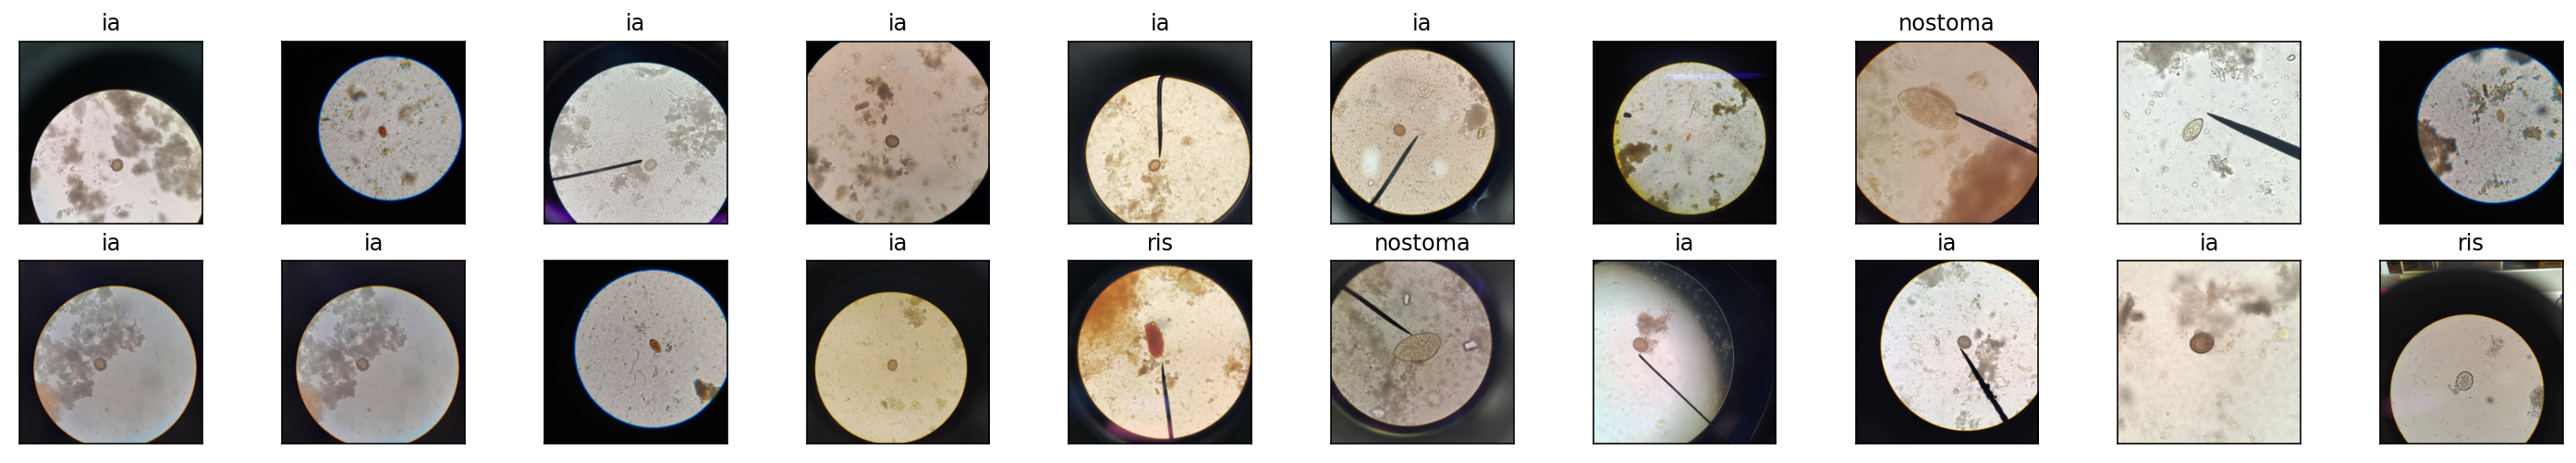

In [120]:
#Display training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20): #only 20 images
  ax = fig.add_subplot(2, 20/2, idx + 1, xticks=[], yticks=[])
  #We don't need axes for the images
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(formatText(classes[labels[idx]]))

#training

In [121]:
#loading model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [122]:
model = models.densenet201(pretrained=True) #using densenet 201

In [123]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [124]:
#We need to change the last layer to have a output shape of 257
print(model.classifier.in_features)
print(model.classifier.out_features)

1920
1000


In [125]:
for param in model.parameters():
  param.requires_grad = False #We are freezing the model since it was trained on imageet and we do not need to train that part agian 

In [126]:
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier = last_layer
print(model.classifier.out_features)

7


In [127]:
#Moving our model to GPU
model = model.to(device)

In [128]:
#Defining our optimizer and loss function
criterion = nn.CrossEntropyLoss() #This is our loss function
optimizer = optim.Adam(model.classifier.parameters()) #Feed parameters to the model

In [129]:
#Training model
training_history = {'accuracy':[], 'loss':[]}
validation_history = {'accuracy':[], 'loss':[]}

In [130]:
#Now we will use PyTorch Ignite's feaures
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model,
                                       device=device,
                                       metrics={
                                           'accuracy':Accuracy(),
                                           'loss': Loss(criterion),
                                           'cm':ConfusionMatrix(len(classes))}
                                      )
#Creating even handlers to show our training progress
@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
  print(".", end="")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  evaluator.run(train_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  training_history['accuracy'].append(accuracy)
  training_history['loss'].append(loss)
  print()
  print(f"Training results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
  evaluator.run(val_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print()
  print(f"Validation results - Epoch: {trainer.state.epoch} Avg accuracy: {accuracy} Loss: {loss}")

In [131]:
trainer.run(train_loader, max_epochs=5)

...........
Training results - Epoch: 1 Avg accuracy: 36.349453978159126 Loss: 1.68224907218945

Validation results - Epoch: 1 Avg accuracy: 33.64485981308411 Loss: 1.7090069066698306
...........
Training results - Epoch: 2 Avg accuracy: 45.70982839313572 Loss: 1.4733428717031494

Validation results - Epoch: 2 Avg accuracy: 39.25233644859813 Loss: 1.5637149989047898
...........
Training results - Epoch: 3 Avg accuracy: 57.25429017160687 Loss: 1.2935567251791633

Validation results - Epoch: 3 Avg accuracy: 52.336448598130836 Loss: 1.3834667740581192
...........
Training results - Epoch: 4 Avg accuracy: 66.45865834633385 Loss: 1.1410500560647425

Validation results - Epoch: 4 Avg accuracy: 55.140186915887845 Loss: 1.2851542535229263
...........
Training results - Epoch: 5 Avg accuracy: 71.13884555382215 Loss: 1.0317512309867394

Validation results - Epoch: 5 Avg accuracy: 62.616822429906534 Loss: 1.211474694938303


State:
	iteration: 55
	epoch: 5
	epoch_length: 11
	max_epochs: 5
	output: 0.9749190807342529
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Testing

Text(0.5, 1.0, 'Validation loss')

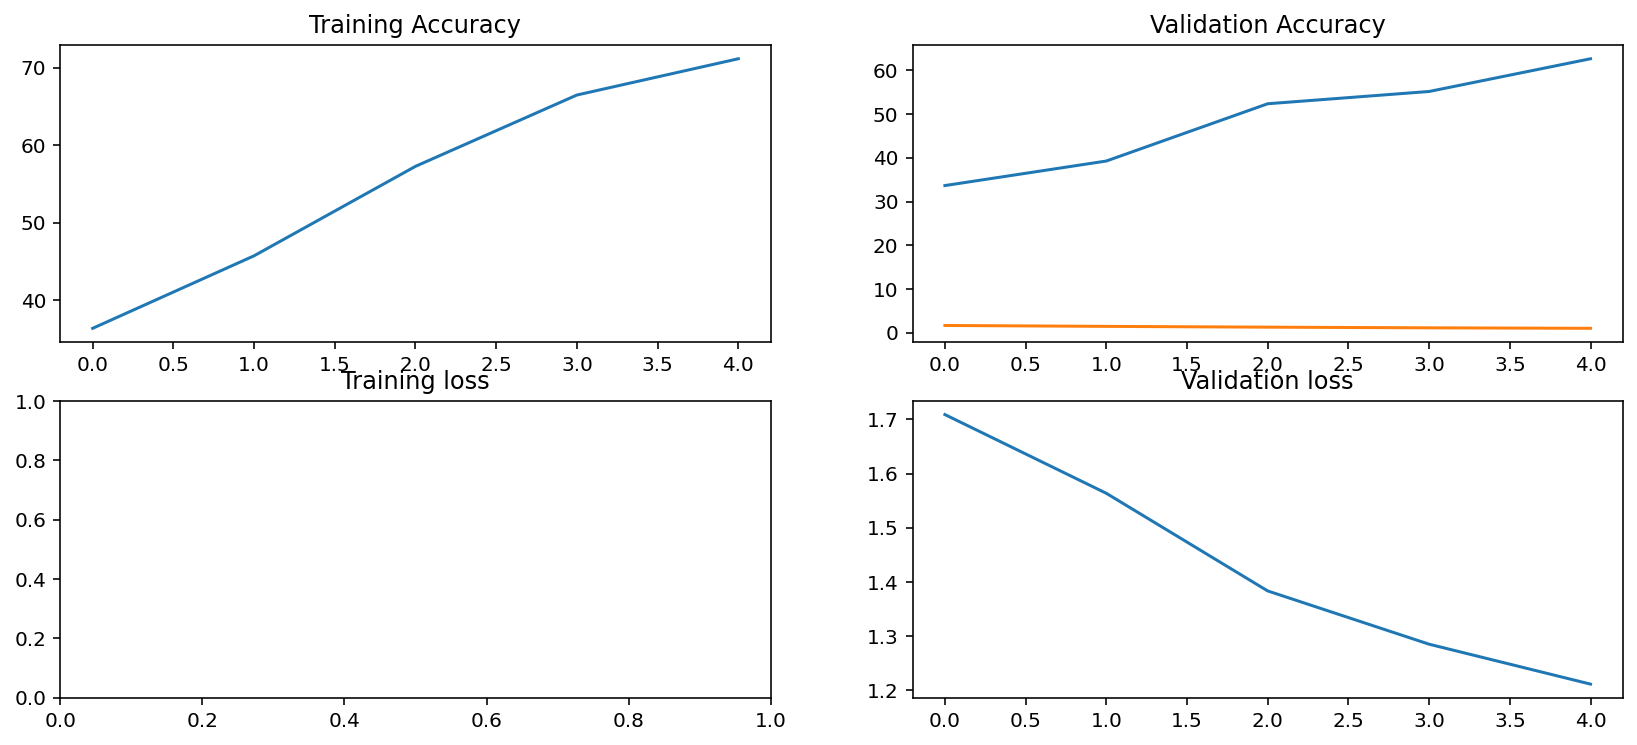

In [132]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(14)
axs[0, 0].plot(training_history["accuracy"])
axs[0, 0].set_title("Training Accuracy")
axs[0, 1].plot(validation_history["accuracy"])
axs[0, 1].set_title("Validation Accuracy")
axs[0, 1].plot(training_history["loss"])
axs[1, 0].set_title("Training loss")
axs[1, 1].plot(validation_history["loss"])
axs[1, 1].set_title("Validation loss")

In [133]:
test_loss = 0.0
class_correct = np.zeros((len(classes)))
class_total = np.zeros((len(classes)))
model.eval() #Setting model to evaluation mode

for data, target in test_loader:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

Test Loss: 1.128889

Test Accuracy of Ascaris: 66.66666666666667 (4.0/6.0)
Test Accuracy of Echinostoma: 50.0 (4.0/8.0)
Test Accuracy of Hookworm: 50.0 (4.0/8.0)
Test Accuracy of MIF: 100.0 (3.0/3.0)
Test Accuracy of OV: 27.272727272727273 (3.0/11.0)
Test Accuracy of Taenia: 80.95238095238095 (17.0/21.0)
Test Accuracy of Trichuris: 57.142857142857146 (4.0/7.0)
Test Accuracy Overall: 60.9375 (39.0/64.0)


In [134]:
(train_loader2, val_loader2, test_loader2), classes2 = get_data_loaders("/content/drive/MyDrive/New_yolo/Densenet/Parasiteaddout", 64)

In [139]:
temper = 1000
test_loss = 0.0
class_correct = np.zeros((len(classes2)))
class_total = np.zeros((len(classes2)))
model.eval()
for data, target in train_loader2:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)

  ####################################
  outputs = output / temper
  nnOutputs = outputs.data.cpu()
  nnOutputs = nnOutputs.numpy()
                          
                  #nnOutputs = nnOutputs[0]

                  #print("nnOutputs2")
                  #print(nnOutputs)
                          
  nnOutputs = nnOutputs - np.max(nnOutputs)                
  nnOutputs = np.exp(nnOutputs)/np.sum(np.exp(nnOutputs))
  max_out1 = np.max(nnOutputs)
  print("________")
  print(output)
  print(max_out1)
  print(target)


  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

________
tensor([[ 3.3880e-01, -1.6746e+00, -9.2624e-01, -1.7868e+00, -1.2306e+00,
          1.8046e-01,  1.2995e-01],
        [ 1.1784e-01, -1.1913e+00,  3.8189e-01, -2.5490e+00, -1.7691e+00,
          7.8405e-01, -1.0825e+00],
        [-9.8847e-01, -7.5088e-01, -2.0587e+00,  1.3151e-01,  2.7437e-01,
          4.6012e-02,  4.9002e-02],
        [-4.8249e-01, -4.3237e-01, -1.5618e+00, -8.5260e-01,  1.0840e-01,
          5.7715e-01, -5.3590e-01],
        [ 8.6861e-01, -1.4122e+00, -2.0713e-01, -1.2751e+00, -1.3316e+00,
         -7.2925e-02,  5.8379e-02],
        [-1.0542e+00, -3.9764e-01, -1.9715e+00, -1.6736e+00, -2.1934e-01,
          8.4682e-02, -1.1394e+00],
        [-5.8612e-01, -1.8705e+00, -1.8946e+00, -2.4568e+00,  5.6563e-01,
          1.1244e+00, -8.5738e-01],
        [ 7.6750e-01, -1.3724e+00, -2.1580e-01, -1.0432e+00, -1.3047e+00,
         -3.0809e-02,  9.9589e-02],
        [ 3.5071e-02, -2.1417e-01, -7.3026e-01, -2.4341e+00, -1.4575e+00,
          9.5221e-01, -6.4728e-01],
 

In [137]:
temper = 1000
test_loss = 0.0
class_correct = np.zeros((len(classes2)))
class_total = np.zeros((len(classes2)))
model.eval()
for data, target in val_loader2:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)

  ####################################
  outputs = output / temper
  nnOutputs = outputs.data.cpu()
  nnOutputs = nnOutputs.numpy()
                          
                  #nnOutputs = nnOutputs[0]

                  #print("nnOutputs2")
                  #print(nnOutputs)
                          
  nnOutputs = nnOutputs - np.max(nnOutputs)                
  nnOutputs = np.exp(nnOutputs)/np.sum(np.exp(nnOutputs))
  max_out1 = np.max(nnOutputs)
  print("________")
  print(output)
  print(max_out1)
  print(target)


  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

________
tensor([[ 4.7044e-01, -9.0512e-01, -8.1620e-01, -1.6389e+00, -5.1816e-01,
          6.9187e-01, -2.8485e-01],
        [-3.6821e-01, -1.0480e+00, -1.3658e+00, -1.6071e+00, -6.5811e-01,
          4.4325e-01, -1.8888e-02],
        [-1.1828e-02, -2.0722e-01, -7.4920e-01, -1.0728e+00, -1.3219e-01,
          1.5505e-01, -3.6917e-01],
        [-7.8721e-01, -9.5659e-01, -2.0833e+00,  3.3758e-01,  2.7853e-01,
         -2.0729e-01,  3.7115e-01],
        [ 2.2450e-01, -1.0958e+00, -2.1845e+00, -2.3324e+00, -5.2989e-01,
          8.4198e-01, -1.8046e-01],
        [-8.5310e-01,  1.2317e+00, -1.8139e+00, -1.5913e+00, -1.3414e+00,
          1.8717e-01, -1.2480e+00],
        [ 1.7386e-01, -9.1749e-01, -1.0512e+00, -1.7443e+00, -1.0731e+00,
          8.0087e-02,  5.3944e-02],
        [ 1.9471e-03, -1.5348e+00, -3.0864e+00, -1.2831e+00, -3.5612e-01,
          1.0366e+00, -6.2609e-01],
        [-9.0346e-01,  3.8155e-01, -2.5534e+00, -1.1994e+00, -4.6163e-01,
         -4.5932e-01, -9.3326e-01],
 

In [138]:
temper = 1000
test_loss = 0.0
class_correct = np.zeros((len(classes2)))
class_total = np.zeros((len(classes2)))
model.eval()
for data, target in test_loader2:
  if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()
  output = model(data)

  ####################################
  outputs = output / temper
  nnOutputs = outputs.data.cpu()
  nnOutputs = nnOutputs.numpy()
                          
                  #nnOutputs = nnOutputs[0]

                  #print("nnOutputs2")
                  #print(nnOutputs)
                          
  nnOutputs = nnOutputs - np.max(nnOutputs)                
  nnOutputs = np.exp(nnOutputs)/np.sum(np.exp(nnOutputs))
  max_out1 = np.max(nnOutputs)
  print("________")
  print(output)
  print(max_out1)
  print(target)


  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  if len(target) == 64:
    for i in range(64):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
test_loss /= len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(len(classes)):
  if class_total[i] > 0:
    print("Test Accuracy of {}: {} ({}/{})".format(
        classes[i], 100*class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])
    ))
  else:
    print("Test Accuracy of {}: N/A (since there are no examples)".format(classes[i]))
print("Test Accuracy Overall: {} ({}/{})".format(
        100*np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)
    ))

________
tensor([[-0.7691, -0.4332, -1.1108, -1.3436,  0.0249,  0.1485,  0.4577],
        [ 0.4038,  0.6405, -1.9319, -1.8540, -1.0969,  0.1450, -0.7950],
        [-0.4522, -0.2915, -1.1628, -0.7189, -0.5139,  0.1265,  0.4152],
        [-0.5981,  0.6151, -0.5870, -1.6931, -1.1211, -0.0623, -0.0839],
        [-1.3261,  0.2662, -0.9220, -1.5841, -0.7520,  0.3320, -0.1737],
        [-0.5927,  0.0256, -1.4360, -1.4393,  0.3440,  0.0596, -0.8658],
        [-0.4288, -0.7526,  0.5019, -1.6518, -1.0530,  0.4516, -0.3278],
        [-0.0678,  0.6350, -2.7125, -1.8316, -0.1447,  0.2484, -1.4464],
        [ 0.6085, -0.8674, -0.0547, -2.3055, -1.0973,  0.6054, -0.5478],
        [-0.6615,  0.3262, -0.2275, -2.0916, -0.8435,  0.2866, -0.3737],
        [ 0.3965, -1.3553, -1.9169, -1.8542,  0.2198,  0.5293, -1.3910],
        [ 1.3654, -2.5013, -1.1185, -1.9827, -1.0103,  0.1266,  0.1175],
        [-0.3852, -1.1476,  0.6867, -1.0243, -0.5251, -0.0385,  0.4278],
        [-0.0849, -1.3518, -1.7017, -1.935